<a href="https://colab.research.google.com/github/Mohamed25092003/Sales-Forecasting-and-Demand-Prediction/blob/Naguib_branch/sales_Depi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [202]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from xgboost import plot_importance
import lightgbm as lgb




In [203]:

!pip install category_encoders




Loading the data

In [204]:
df= pd.read_csv("/content/sales_dataset.csv")
df.head()

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
0,Sub-Saharan Africa,South Africa,Fruits,Offline,M,2012-07-27,443368995,2012-07-28,611265,38.26,12.67,23386998.90,7744727.55,15642271.35
1,Middle East and North Africa,Morocco,Clothes,Online,M,2013-09-14,667593514,2013-10-19,545518,145.65,79.81,79454696.70,43537791.58,35916905.12
2,Australia and Oceania,Papua New Guinea,Meat,Offline,M,2015-05-15,940995585,2015-06-04,326908,186.66,94.10,61020647.28,30762042.80,30258604.48
3,Sub-Saharan Africa,Djibouti,Clothes,Offline,H,2017-05-17,880811536,2017-07-02,431659,144.86,66.93,62530122.74,28890936.87,33639185.87
4,Europe,Slovakia,Beverages,Offline,L,2016-10-26,174590194,2016-12-04,625973,15.86,6.30,9927931.78,3943629.90,5984301.88


In [205]:
df.duplicated().sum()

np.int64(0)

In [206]:
df.drop_duplicates(inplace=True)

In [493]:
##### for modeling ######
df_Baby_food=df[df["Item Type"]=='Baby Food'].copy()
df_Baby_food.shape

(82929, 14)

In [494]:
df_Baby_food.columns

Index(['Region', 'Country', 'Item Type', 'Sales Channel', 'Order Priority',
       'Order Date', 'Order ID', 'Ship Date', 'Units Sold', 'Unit Price',
       'Unit Cost', 'Total Revenue', 'Total Cost', 'Total Profit'],
      dtype='object')

In [495]:
df_Baby_food.drop_duplicates(inplace=True)
df_Baby_food['Order Date'] = pd.to_datetime(df_Baby_food['Order Date'])
df_Baby_food['Ship Date'] = pd.to_datetime(df_Baby_food['Ship Date'])


In [496]:
df_Baby_food.head()

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
24,Central America and the Caribbean,Dominican Republic,Baby Food,Offline,H,2011-08-25,824714744,2011-09-24,409168,73.91,25.82,30241606.88,10564717.76,19676889.12
67,Europe,Iceland,Baby Food,Offline,M,2010-10-02,678230941,2010-11-03,372191,77.67,34.45,28908074.97,12821979.95,16086095.02
74,Australia and Oceania,Tonga,Baby Food,Online,L,2016-05-11,839094388,2016-05-31,430105,79.74,30.66,34296572.70,13187019.30,21109553.40
82,Europe,Albania,Baby Food,Offline,H,2012-07-19,752525556,2012-08-13,469245,83.65,35.59,39252344.25,16700429.55,22551914.70
84,Central America and the Caribbean,Nicaragua,Baby Food,Online,L,2016-11-11,343752610,2016-11-16,329017,76.17,34.96,25061224.89,11502434.32,13558790.57


In [499]:
### encoding ####
from category_encoders import TargetEncoder
encoder = TargetEncoder()
df_Baby_food[["Region", "Country", "Sales Channel", "Order Priority"]] = encoder.fit_transform(
    df_Baby_food[["Region", "Country", "Sales Channel", "Order Priority"]],
    df_Baby_food["Units Sold"]
)

In [500]:
df_Baby_food.head()

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
24,355177.548376,357042.813636,Baby Food,357963.690372,417808.795811,2011-08-25,824714744,2011-09-24,409168,73.91,25.82,30241606.88,10564717.76,19676889.12
67,359975.502060,350918.067757,Baby Food,357963.690372,369196.408996,2010-10-02,678230941,2010-11-03,372191,77.67,34.45,28908074.97,12821979.95,16086095.02
74,355446.530330,352631.668889,Baby Food,358392.100985,335282.941225,2016-05-11,839094388,2016-05-31,430105,79.74,30.66,34296572.70,13187019.30,21109553.40
82,359975.502060,357600.857143,Baby Food,357963.690372,417808.795811,2012-07-19,752525556,2012-08-13,469245,83.65,35.59,39252344.25,16700429.55,22551914.70
84,355177.548376,352416.246050,Baby Food,358392.100985,335282.941225,2016-11-11,343752610,2016-11-16,329017,76.17,34.96,25061224.89,11502434.32,13558790.57


In [501]:
df_Baby_food.drop(["Item Type","Order ID"],axis=1,inplace=True)

In [502]:
df_Baby_food.columns

Index(['Region', 'Country', 'Sales Channel', 'Order Priority', 'Order Date',
       'Ship Date', 'Units Sold', 'Unit Price', 'Unit Cost', 'Total Revenue',
       'Total Cost', 'Total Profit'],
      dtype='object')

In [503]:
df_Baby_food["time_interval"]=df_Baby_food["Ship Date"]-df_Baby_food["Order Date"]

df_Baby_food["year"] = df_Baby_food["Order Date"].dt.year
df_Baby_food["month"] = df_Baby_food["Order Date"].dt.month
df_Baby_food["day"] = df_Baby_food["Order Date"].dt.day
df_Baby_food["dayofweek"] = df_Baby_food["Order Date"].dt.dayofweek
df_Baby_food["is_weekend"] = df_Baby_food["dayofweek"] >= 5
df_Baby_food["is_weekend"]=df_Baby_food["is_weekend"].astype(int)

In [504]:
# Ensure data is sorted by date
df_Baby_food = df_Baby_food.sort_values(by='Order Date')
# Convert timedelta to number of days
df_Baby_food["time_interval"] = df_Baby_food["time_interval"].dt.days




In [505]:
df_Baby_food.columns

Index(['Region', 'Country', 'Sales Channel', 'Order Priority', 'Order Date',
       'Ship Date', 'Units Sold', 'Unit Price', 'Unit Cost', 'Total Revenue',
       'Total Cost', 'Total Profit', 'time_interval', 'year', 'month', 'day',
       'dayofweek', 'is_weekend'],
      dtype='object')

In [506]:
df_Baby_food.drop(["Order Date","Total Cost","Total Profit","Ship Date"],axis=1,inplace=True)

In [507]:
df_Baby_food.head(10)

,Region,Country,Sales Channel,Order Priority,Units Sold,Unit Price,Unit Cost,Total Revenue,time_interval,year,month,day,dayofweek,is_weekend
850024,359975.502060,355832.331066,357963.690372,417808.795811,332543,78.02,35.81,25945004.86,6,2010,1,1,4,0
333794,355177.548376,361738.826291,357963.690372,335282.941225,318359,74.33,31.74,23663624.47,45,2010,1,1,4,0
75258,360010.470872,351912.655889,358392.100985,311177.446452,278129,77.89,26.67,21663467.81,7,2010,1,1,4,0
591691,357286.341199,354294.006565,358392.100985,311177.446452,204315,80.11,36.31,16367674.65,2,2010,1,1,4,0
274231,359975.502060,365524.179654,358392.100985,417808.795811,460357,87.47,38.18,40267426.79,8,2010,1,1,4,0
600111,359975.502060,360676.624719,358392.100985,369196.408996,419379,75.44,29.79,31637951.76,49,2010,1,1,4,0
479224,357286.341199,356984.810870,357963.690372,417808.795811,380481,84.97,35.22,32329470.57,2,2010,1,1,4,0
55459,356277.987807,363383.864055,357963.690372,369196.408996,352417,82.02,33.66,28905242.34,0,2010,1,1,4,0
579183,355177.548376,354855.896163,358392.100985,417808.795811,296135,73.06,29.06,21635623.10,50,2010,1,1,4,0
993838,360010.470872,356528.420225,358392.100985,369196.408996,318495,80.16,35.55,25530559.20,2,2010,1,1,4,0


In [508]:
df_Baby_food.describe()

,Region,Country,Sales Channel,Order Priority,Units Sold,Unit Price,Unit Cost,Total Revenue,time_interval,year,month,day,dayofweek,is_weekend
count,82929.000000,82929.000000,82929.000000,82929.000000,82929.000000,82929.000000,82929.000000,8.292900e+04,82929.000000,82929.000000,82929.000000,82929.000000,82929.000000,82929.000000
mean,358178.239217,358178.239217,358178.239217,358178.239217,358178.239217,79.990841,32.002924,2.865152e+07,25.033655,2013.303079,6.318851,15.718072,3.003292,0.286378
std,1978.278947,12925.960092,214.206323,40035.457311,70307.234637,4.621951,3.342569,5.870451e+06,14.730997,2.196047,3.422693,8.788327,1.998848,0.452071
min,355177.548376,342718.614894,357963.690372,311177.446452,131657.000000,72.000000,24.510000,1.001120e+07,0.000000,2010.000000,1.000000,1.000000,0.000000,0.000000
25%,356277.987807,352612.242563,357963.690372,311177.446452,308768.000000,75.980000,29.490000,2.450250e+07,12.000000,2011.000000,3.000000,8.000000,1.000000,0.000000
50%,359975.502060,356445.750577,358392.100985,335282.941225,353427.000000,79.990000,31.890000,2.819769e+07,25.000000,2013.000000,6.000000,16.000000,3.000000,0.000000
75%,360010.470872,360123.171247,358392.100985,369196.408996,402369.000000,83.990000,34.420000,3.235169e+07,38.000000,2015.000000,9.000000,23.000000,5.000000,1.000000
max,360010.470872,431592.574561,358392.100985,417808.795811,742142.000000,88.000000,40.430000,6.163457e+07,50.000000,2017.000000,12.000000,31.000000,6.000000,1.000000


In [509]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# df_Baby_food['Units Sold'] = scaler.fit_transform(df_Baby_food[['Units Sold']])
# df_Baby_food['Country'] = scaler.fit_transform(df_Baby_food[['Country']])

In [569]:
df_Baby_food['lag_1_units_sold'] = df_Baby_food['Units Sold'].shift(1)
df_Baby_food['lag_7_units_sold'] = df_Baby_food['Units Sold'].shift(7)
df_Baby_food['lag_30_units_sold'] = df_Baby_food['Units Sold'].shift(30)
df_Baby_food['lag_14_units_sold'] = df_Baby_food['Units Sold'].shift(14)
df_Baby_food['lag_21_units_sold'] = df_Baby_food['Units Sold'].shift(21)


df_Baby_food['lag_1_rev'] = df_Baby_food['Total Revenue'].shift(1)
df_Baby_food['lag_7_rev'] = df_Baby_food['Total Revenue'].shift(7)

df_Baby_food = df_Baby_food.dropna()


In [570]:
# Compute 7-row and 30-row rolling averages (assumes ~daily data)
df_Baby_food['Rolling_7d_Avg_Units_Sold'] = df_Baby_food['Units Sold'].rolling(window=7).mean()
df_Baby_food['Rolling_30d_Avg_Units_Sold'] = df_Baby_food['Units Sold'].rolling(window=30).mean()
df_Baby_food['Rolling_60d_Avg_Units_Sold'] = df_Baby_food['Units Sold'].rolling(window=60).mean()
df_Baby_food['Rolling_90d_Avg_Units_Sold'] = df_Baby_food['Units Sold'].rolling(window=90).mean()

df_Baby_food['Rolling_7d_Avg_rev'] = df_Baby_food['Total Revenue'].rolling(window=7).mean()
df_Baby_food['Rolling_30d_Avg_rev'] = df_Baby_food['Total Revenue'].rolling(window=30).mean()
df_Baby_food['Rolling_60d_Avg_rev'] = df_Baby_food['Total Revenue'].rolling(window=60).mean()
df_Baby_food['Rolling_90d_Avg_rev'] = df_Baby_food['Total Revenue'].rolling(window=90).mean()

# Drop rows with NaN from rolling averages (usually first 29 rows for 30-day avg)
df_Baby_food = df_Baby_food.dropna(subset=["Rolling_7d_Avg_Units_Sold", "Rolling_30d_Avg_Units_Sold"])

In [571]:
df_Baby_food.describe()

,Region,Country,Sales Channel,Order Priority,Units Sold,Unit Price,Unit Cost,Total Revenue,time_interval,year,...,Rolling_60d_Avg_Units_Sold,Rolling_90d_Avg_Units_Sold,Rolling_7d_Avg_rev,Rolling_30d_Avg_rev,Rolling_60d_Avg_rev,Rolling_90d_Avg_rev,lag_14_units_sold,lag_21_units_sold,lag_1_rev,lag_7_rev
count,82632.000000,82632.000000,82632.000000,82632.000000,82632.000000,82632.000000,82632.000000,8.263200e+04,82632.000000,82632.000000,...,82602.000000,82572.000000,8.263200e+04,8.263200e+04,8.260200e+04,8.257200e+04,82632.000000,82632.000000,8.263200e+04,8.263200e+04
mean,358177.846264,358176.489935,358178.274151,358183.696447,358204.382951,79.992001,32.003543,2.865414e+07,25.078323,2013.314951,...,358203.358234,358207.617127,2.865404e+07,2.865351e+07,2.865397e+07,2.865430e+07,358196.351159,358193.275632,2.865415e+07,2.865372e+07
std,1978.269090,12929.161987,214.206268,40034.071646,70296.889177,4.621990,3.342695,5.870308e+06,14.725878,2.191027,...,13536.789443,12505.847296,2.339332e+06,1.332926e+06,1.104128e+06,1.015880e+06,70295.398761,70293.235908,5.870294e+06,5.870176e+06
min,355177.548376,342718.614894,357963.690372,311177.446452,131657.000000,72.000000,24.510000,1.001120e+07,0.000000,2010.000000,...,317983.183333,327062.433333,2.095609e+07,2.410867e+07,2.505895e+07,2.597593e+07,131657.000000,131657.000000,1.001120e+07,1.001120e+07
25%,356277.987807,352612.242563,357963.690372,311177.446452,308828.250000,75.980000,29.490000,2.450633e+07,12.000000,2011.000000,...,349908.079167,350747.250000,2.705314e+07,2.777280e+07,2.796708e+07,2.804112e+07,308822.500000,308818.750000,2.450633e+07,2.450643e+07
50%,359975.502060,356445.750577,358392.100985,335282.941225,353478.000000,79.990000,31.890000,2.820411e+07,25.000000,2013.000000,...,356124.008333,355937.483333,2.855123e+07,2.852202e+07,2.848754e+07,2.847126e+07,353467.000000,353467.000000,2.820411e+07,2.820357e+07
75%,360010.470872,360123.171247,358392.100985,369196.408996,402387.500000,83.990000,34.420000,3.235450e+07,38.000000,2015.000000,...,363366.375000,362130.005556,3.015285e+07,2.932977e+07,2.908077e+07,2.898851e+07,402369.500000,402362.250000,3.235450e+07,3.235386e+07
max,360010.470872,431592.574561,358392.100985,417808.795811,742142.000000,88.000000,40.430000,6.163457e+07,50.000000,2017.000000,...,422501.850000,415885.144444,3.989933e+07,3.589781e+07,3.385955e+07,3.332743e+07,742142.000000,742142.000000,6.163457e+07,6.163457e+07


In [572]:
df_Baby_food.dropna(inplace=True)


In [573]:

df_Baby_food.columns

Index(['Region', 'Country', 'Sales Channel', 'Order Priority', 'Units Sold',
       'Unit Price', 'Unit Cost', 'Total Revenue', 'time_interval', 'year',
       'month', 'day', 'dayofweek', 'is_weekend', 'lag_1_units_sold',
       'lag_7_units_sold', 'lag_30_units_sold', 'Rolling_7d_Avg_Units_Sold',
       'Rolling_30d_Avg_Units_Sold', 'Rolling_60d_Avg_Units_Sold',
       'Rolling_90d_Avg_Units_Sold', 'Rolling_7d_Avg_rev',
       'Rolling_30d_Avg_rev', 'Rolling_60d_Avg_rev', 'Rolling_90d_Avg_rev',
       'lag_14_units_sold', 'lag_21_units_sold', 'lag_1_rev', 'lag_7_rev'],
      dtype='object')

In [576]:
# Choose features
features = ['Region', 'Country', 'Sales Channel', 'Order Priority',
       'Unit Price', 'Unit Cost', 'time_interval', 'year',
       'month', 'day', 'dayofweek', 'is_weekend', 'Rolling_7d_Avg_Units_Sold',
       'Rolling_30d_Avg_Units_Sold', 'lag_1_units_sold', 'lag_7_units_sold',
       'lag_30_units_sold', 'lag_14_units_sold', 'lag_21_units_sold',"lag_1_rev","lag_7_rev"
            ]


In [577]:
train_size = int(len(df_Baby_food) * 0.6)
val_size = int(len(df_Baby_food) * 0.8)
train, validate,test = df_Baby_food[:train_size],df_Baby_food[train_size:val_size] ,df_Baby_food[val_size:]

X_train = train[features]
y_train = train["Units Sold"]
X_cv = validate[features]
y_cv = validate["Units Sold"]
X_test = test[features]
y_test = test["Units Sold"]
# y_train_log = np.log1p(y_train)

# y_test_log = np.log1p(y_test)g

In [578]:

from sklearn.linear_model import LinearRegression
model=LinearRegression()
model.fit(X_train, y_train)



LinearRegression()

In [579]:

cv_predictions = model.predict(X_cv)
predictions = model.predict(X_test)



In [580]:
from sklearn.metrics import mean_squared_error,r2_score
r2 = r2_score(y_cv, cv_predictions)
print("validation R² Score:", r2)
mse = mean_squared_error(y_cv, cv_predictions)
print("Validation MSE:", mse)

print("------------------")

r2 = r2_score(y_test, predictions)
print(" Test R² Score:", r2)
mse = mean_squared_error(y_test, predictions)
print("Test MSE:", mse)

validation R² Score: 0.45198910579217755
Validation MSE: 2737889255.2440143
------------------
 Test R² Score: 0.4446431139766107
Test MSE: 2724351607.6289535


In [520]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler



model = RandomForestRegressor(n_estimators=100, random_state=42) # You can tune n_estimators
model.fit(X_train, y_train)
predictions = model.predict(X_test)






KeyboardInterrupt: 

In [233]:
cv_predictions = model.predict(X_cv)
predictions = model.predict(X_test)



In [234]:
from sklearn.metrics import mean_squared_error,r2_score
r2 = r2_score(y_cv, cv_predictions)
print("validation R² Score:", r2)
mse = mean_squared_error(y_cv, cv_predictions)
print("Validation MSE:", mse)

print("------------------")

r2 = r2_score(y_test, predictions)
print(" Test R² Score:", r2)
mse = mean_squared_error(y_test, predictions)
print("Test MSE:", mse)

validation R² Score: 0.4540707497815941
Validation MSE: 2708978880.246555
------------------
 Test R² Score: 0.45424802194631264
Test MSE: 2679420884.573669


In [581]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=3)
model.fit(X_train, y_train)


predictions = model.predict(X_test)




In [582]:



cv_predictions = model.predict(X_cv)
predictions = model.predict(X_test)



In [583]:

from sklearn.metrics import mean_squared_error,r2_score
r2 = r2_score(y_cv, cv_predictions)
print("validation R² Score:", r2)
mse = mean_squared_error(y_cv, cv_predictions)
print("Validation MSE:", mse)

print("------------------")

r2 = r2_score(y_test, predictions)
print(" Test R² Score:", r2)
mse = mean_squared_error(y_test, predictions)
print("Test MSE:", mse)

validation R² Score: 0.47302818298339844
Validation MSE: 2632776704.0
------------------
 Test R² Score: 0.4695699214935303
Test MSE: 2602070784.0


In [524]:
# from xgboost import XGBRegressor
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [50,100, 200,300],
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.8, 1.0],
# }

# xgb = XGBRegressor(random_state=42)
# grid = GridSearchCV(xgb, param_grid, cv=None, scoring='r2', verbose=1)
# grid.fit(X_train, y_train)

# print("Best params:", grid.best_params_)
# best_model = grid.best_estimator_



In [525]:
# cv_predictions = model.predict(X_cv)
# predictions = model.predict(X_test)



In [526]:
# from sklearn.metrics import mean_squared_error,r2_score
# r2 = r2_score(y_cv, cv_predictions)
# print("validation R² Score:", r2)
# mse = mean_squared_error(y_cv, cv_predictions)
# print("Validation MSE:", mse)

# print("------------------")

# r2 = r2_score(y_test, predictions)
# print(" Test R² Score:", r2)
# mse = mean_squared_error(y_test, predictions)
# print("Test MSE:", mse)


In [584]:
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    early_stopping_rounds=50,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=10
)


y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))

[0]	validation_0-rmse:68505.06408
[10]	validation_0-rmse:58374.18469
[20]	validation_0-rmse:54108.33294
[30]	validation_0-rmse:52356.40747
[40]	validation_0-rmse:51604.23444
[50]	validation_0-rmse:51280.47211
[60]	validation_0-rmse:51117.52012
[70]	validation_0-rmse:51051.99082
[80]	validation_0-rmse:51018.96347
[90]	validation_0-rmse:51012.22238
[100]	validation_0-rmse:51006.07156
[110]	validation_0-rmse:51001.26690
[120]	validation_0-rmse:50994.05546
[130]	validation_0-rmse:50997.01424
[140]	validation_0-rmse:51009.33079
[150]	validation_0-rmse:51010.93579
[160]	validation_0-rmse:51019.16194
[170]	validation_0-rmse:51028.64614
[176]	validation_0-rmse:51034.26848
MAE: 40264.31640625
RMSE: 50993.134596727825
R² Score: 0.4699309468269348


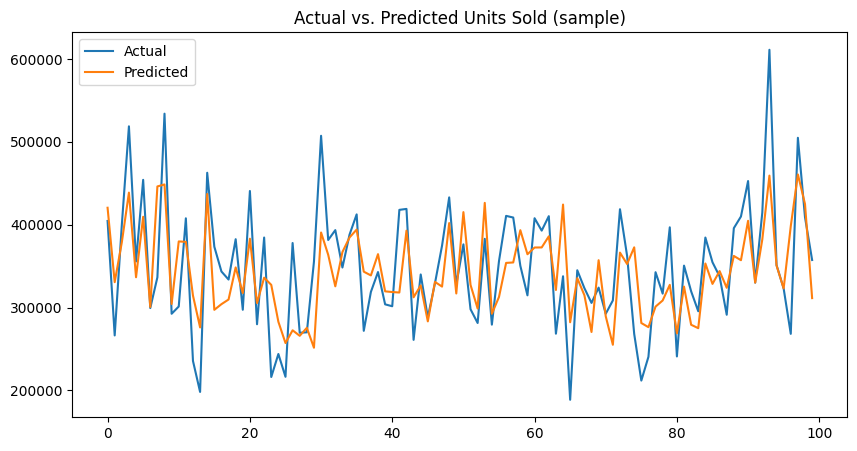

In [239]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(predictions[:100], label='Predicted')
plt.legend()
plt.title("Actual vs. Predicted Units Sold (sample)")
plt.show()



In [463]:
##### for modeling ######
df_Clothes=df[df["Item Type"]=='Clothes'].copy()
df_Clothes.shape

(82813, 14)

In [464]:
df_Clothes.columns

Index(['Region', 'Country', 'Item Type', 'Sales Channel', 'Order Priority',
       'Order Date', 'Order ID', 'Ship Date', 'Units Sold', 'Unit Price',
       'Unit Cost', 'Total Revenue', 'Total Cost', 'Total Profit'],
      dtype='object')

In [465]:

df_Clothes.drop_duplicates(inplace=True)
df_Clothes['Order Date'] = pd.to_datetime(df_Clothes['Order Date'])
df_Clothes['Ship Date'] = pd.to_datetime(df_Clothes['Ship Date'])


In [466]:
### encoding ####
from category_encoders import TargetEncoder
encoder = TargetEncoder()
df_Clothes[["Region", "Country", "Sales Channel", "Order Priority"]] = encoder.fit_transform(
    df_Clothes[["Region", "Country", "Sales Channel", "Order Priority"]],
    df_Clothes["Units Sold"]
)

In [467]:

df_Clothes.drop(["Item Type","Order ID"],axis=1,inplace=True)

In [468]:

df_Clothes.columns

Index(['Region', 'Country', 'Sales Channel', 'Order Priority', 'Order Date',
       'Ship Date', 'Units Sold', 'Unit Price', 'Unit Cost', 'Total Revenue',
       'Total Cost', 'Total Profit'],
      dtype='object')

In [471]:
df_Clothes["time_interval"]=df_Clothes["Ship Date"]-df_Clothes["Order Date"]
df_Clothes['quarter'] = df_Clothes['Order Date'].dt.quarter
df_Clothes["year"] = df_Clothes["Order Date"].dt.year
df_Clothes["month"] = df_Clothes["Order Date"].dt.month
df_Clothes["day"] = df_Clothes["Order Date"].dt.day
df_Clothes["dayofweek"] = df_Clothes["Order Date"].dt.dayofweek
df_Clothes["is_weekend"] = df_Clothes["dayofweek"] >= 5
df_Clothes["is_weekend"]=df_Clothes["is_weekend"].astype(int)

In [472]:
# Ensure data is sorted by date
df_Clothes = df_Clothes.sort_values(by='Order Date')
# Convert timedelta to number of days
df_Clothes["time_interval"] = df_Clothes["time_interval"].dt.days




In [473]:
df_Clothes.columns

Index(['Region', 'Country', 'Sales Channel', 'Order Priority', 'Order Date',
       'Ship Date', 'Units Sold', 'Unit Price', 'Unit Cost', 'Total Revenue',
       'Total Cost', 'Total Profit', 'time_interval', 'year', 'month', 'day',
       'dayofweek', 'is_weekend', 'quarter'],
      dtype='object')

In [474]:
df_Clothes.drop(["Order Date","Total Cost","Total Profit","Ship Date"],axis=1,inplace=True)

In [475]:
df_Clothes.head(10)

,Region,Country,Sales Channel,Order Priority,Units Sold,Unit Price,Unit Cost,Total Revenue,time_interval,year,month,day,dayofweek,is_weekend,quarter
770975,388079.796172,384631.440000,385085.648925,447876.616752,362251,159.05,85.92,57616021.55,49,2010,1,1,4,0,1
649294,386433.565688,377337.763797,385085.648925,447876.616752,554618,136.63,72.18,75777457.34,2,2010,1,1,4,0,1
205690,386433.565688,376801.223176,385187.499843,447876.616752,511136,164.60,89.63,84132985.60,49,2010,1,1,4,0,1
883015,383581.319003,387339.864444,385085.648925,359462.001878,342816,155.43,87.71,53283890.88,49,2010,1,1,4,0,1
649657,386433.565688,380171.674468,385187.499843,397624.655593,495377,142.06,80.91,70373256.62,10,2010,1,1,4,0,1
100866,382280.329131,371764.390351,385187.499843,397624.655593,371288,154.37,76.60,57315728.56,47,2010,1,1,4,0,1
697871,383581.319003,376528.046256,385085.648925,335212.390843,335949,161.34,92.36,54202011.66,3,2010,1,1,4,0,1
1607,388079.796172,370753.637647,385187.499843,359462.001878,506165,145.60,65.60,73697624.00,46,2010,1,1,4,0,1
614168,382406.626673,390899.709302,385085.648925,447876.616752,478873,153.68,66.78,73593202.64,46,2010,1,1,4,0,1
782020,386433.565688,400348.298441,385187.499843,397624.655593,410985,149.06,80.32,61261424.10,47,2010,1,1,4,0,1


In [476]:
df_Clothes.describe()

,Region,Country,Sales Channel,Order Priority,Units Sold,Unit Price,Unit Cost,Total Revenue,time_interval,year,month,day,dayofweek,is_weekend,quarter
count,82813.000000,82813.000000,82813.000000,82813.000000,82813.000000,82813.000000,82813.000000,8.281300e+04,82813.000000,82813.000000,82813.000000,82813.000000,82813.000000,82813.000000,82813.000000
mean,385136.570080,385136.570080,385136.570080,385136.570080,385136.570080,150.033636,75.013204,5.778493e+07,24.962433,2013.298250,6.346202,15.745825,2.998116,0.285921,2.452984
std,2355.490562,14102.519638,50.925766,42602.622891,89160.280198,8.659648,7.810689,1.381165e+07,14.749997,2.196551,3.434372,8.795710,2.000717,0.451855,1.111813
min,382241.244063,369633.717195,385085.648925,335212.390843,128580.000000,135.000000,57.410000,1.877188e+07,0.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,1.000000
25%,382406.626673,378275.961290,385085.648925,359462.001878,320980.000000,142.600000,69.150000,4.786214e+07,12.000000,2011.000000,3.000000,8.000000,1.000000,0.000000,1.000000
50%,386433.565688,383131.147903,385085.648925,397624.655593,375736.000000,150.010000,74.780000,5.631610e+07,25.000000,2013.000000,6.000000,16.000000,3.000000,0.000000,2.000000
75%,388079.796172,387240.291855,385187.499843,447876.616752,439919.000000,157.530000,80.660000,6.617464e+07,38.000000,2015.000000,9.000000,23.000000,5.000000,1.000000,3.000000
max,388079.796172,465252.177570,385187.499843,447876.616752,880768.000000,165.000000,94.840000,1.363157e+08,50.000000,2017.000000,12.000000,31.000000,6.000000,1.000000,4.000000


In [477]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_Clothes['Units Sold'] = scaler.fit_transform(df_Clothes[['Units Sold']])
df_Clothes['Total Revenue'] = scaler.fit_transform(df_Clothes[['Total Revenue']])

In [478]:
df_Clothes['lag_1_units_sold'] = df_Clothes['Units Sold'].shift(1)
df_Clothes['lag_7_units_sold'] = df_Clothes['Units Sold'].shift(7)
df_Clothes['lag_30_units_sold'] = df_Clothes['Units Sold'].shift(30)
df_Clothes['lag_14_units_sold'] = df_Clothes['Units Sold'].shift(14)
df_Clothes['lag_21_units_sold'] = df_Clothes['Units Sold'].shift(21)

df_Clothes['lag_1_rev'] = df_Clothes['Total Revenue'].shift(1)
df_Clothes['lag_7_rev'] = df_Clothes['Total Revenue'].shift(7)
df_Clothes['lag_30_rev'] = df_Clothes['Total Revenue'].shift(30)

# df_Clothes['lag_7_units_sold'] = df_Clothes['Units Sold'].shift(7)
# df_Clothes['rolling_7d_units_sold'] = df_Clothes['Units Sold'].rolling(window=7).mean()
df_Clothes = df_Clothes.dropna()


In [479]:
# Compute 7-row and 30-row rolling averages (assumes ~daily data)
df_Clothes['Rolling_7d_Avg_Units_Sold'] = df_Clothes['Units Sold'].rolling(window=7).mean()
df_Clothes['Rolling_30d_Avg_Units_Sold'] = df_Clothes['Units Sold'].rolling(window=30).mean()
df_Clothes['Rolling_60d_Avg_Units_Sold'] = df_Clothes['Units Sold'].rolling(window=60).mean()
df_Clothes['Rolling_90d_Avg_Units_Sold'] = df_Clothes['Units Sold'].rolling(window=90).mean()

df_Clothes['Rolling_14d_Avg_Units_Sold'] = df_Clothes['Units Sold'].rolling(window=14).mean()
df_Clothes['Rolling_21d_Avg_Units_Sold'] = df_Clothes['Units Sold'].rolling(window=21).mean()



# Drop rows with NaN from rolling averages (usually first 29 rows for 30-day avg)
df_Clothes = df_Clothes.dropna(subset=["Rolling_7d_Avg_Units_Sold", "Rolling_30d_Avg_Units_Sold"])

In [480]:
df_Clothes.describe()

,Region,Country,Sales Channel,Order Priority,Units Sold,Unit Price,Unit Cost,Total Revenue,time_interval,year,...,lag_21_units_sold,lag_1_rev,lag_7_rev,lag_30_rev,Rolling_7d_Avg_Units_Sold,Rolling_30d_Avg_Units_Sold,Rolling_60d_Avg_Units_Sold,Rolling_90d_Avg_Units_Sold,Rolling_14d_Avg_Units_Sold,Rolling_21d_Avg_Units_Sold
count,82754.000000,82754.000000,82754.000000,82754.000000,82754.000000,82754.000000,82754.000000,82754.000000,82754.000000,82754.000000,...,82754.000000,82754.000000,82754.000000,82754.000000,82754.000000,82754.000000,82724.000000,82694.000000,82754.000000,82754.000000
mean,385136.514071,385137.190160,385136.573153,385131.488509,-0.000373,150.032237,75.012366,-0.000398,24.966841,2013.300602,...,-0.000494,-0.000400,-0.000500,-0.000597,-0.000419,-0.000480,-0.000698,-0.000935,-0.000451,-0.000459
std,2355.529637,14103.703036,50.925766,42602.209866,0.999949,8.659752,7.809653,0.999948,14.745063,2.195568,...,0.999834,0.999948,0.999826,0.999781,0.622557,0.556913,0.545069,0.539931,0.580917,0.566200
min,382241.244063,369633.717195,385085.648925,335212.390843,-2.877493,135.000000,57.410000,-2.824665,0.000000,2010.000000,...,-2.877493,-2.824665,-2.824665,-2.824665,-1.627959,-1.153810,-1.042910,-0.988444,-1.397240,-1.208368
25%,382406.626673,378275.961290,385085.648925,359462.001878,-0.720017,142.600000,69.150000,-0.719037,12.000000,2011.000000,...,-0.719995,-0.719037,-0.719037,-0.719037,-0.480177,-0.417513,-0.393843,-0.381145,-0.450077,-0.434051
50%,386433.565688,383131.147903,385085.648925,378543.328736,-0.105727,150.000000,74.780000,-0.106798,25.000000,2013.000000,...,-0.106203,-0.106824,-0.106871,-0.106950,-0.082292,-0.123375,-0.130926,-0.130843,-0.100778,-0.114253
75%,388079.796172,387240.291855,385187.499843,447876.616752,0.613973,157.530000,80.650000,0.607136,38.000000,2015.000000,...,0.613850,0.607136,0.607069,0.606918,0.450788,0.474861,0.474352,0.470644,0.460753,0.468523
max,388079.796172,465252.177570,385187.499843,447876.616752,5.558915,165.000000,94.840000,5.685867,50.000000,2017.000000,...,5.558915,5.685867,5.685867,5.685867,2.493686,1.625166,1.319486,1.226242,2.022251,1.758321


In [481]:
df_Clothes.dropna(inplace=True)


In [482]:
df_Clothes.columns

Index(['Region', 'Country', 'Sales Channel', 'Order Priority', 'Units Sold',
       'Unit Price', 'Unit Cost', 'Total Revenue', 'time_interval', 'year',
       'month', 'day', 'dayofweek', 'is_weekend', 'quarter',
       'lag_1_units_sold', 'lag_7_units_sold', 'lag_30_units_sold',
       'lag_14_units_sold', 'lag_21_units_sold', 'lag_1_rev', 'lag_7_rev',
       'lag_30_rev', 'Rolling_7d_Avg_Units_Sold', 'Rolling_30d_Avg_Units_Sold',
       'Rolling_60d_Avg_Units_Sold', 'Rolling_90d_Avg_Units_Sold',
       'Rolling_14d_Avg_Units_Sold', 'Rolling_21d_Avg_Units_Sold'],
      dtype='object')

In [484]:

# Choose features
features = ['Region', 'Country', 'Sales Channel', 'Order Priority',
       'Unit Price', 'Unit Cost', 'time_interval', 'year',
       'month', 'day', 'dayofweek', 'is_weekend', "quarter",
        'Rolling_7d_Avg_Units_Sold','Rolling_30d_Avg_Units_Sold','Rolling_60d_Avg_Units_Sold','Rolling_90d_Avg_Units_Sold','Rolling_14d_Avg_Units_Sold','Rolling_21d_Avg_Units_Sold',
        'lag_1_units_sold', 'lag_7_units_sold','lag_30_units_sold', 'lag_14_units_sold','lag_21_units_sold'
       ]


In [485]:
train_size = int(len(df_Clothes) * 0.6)
val_size = int(len(df_Clothes) * 0.8)
train, validate,test = df_Clothes[:train_size],df_Clothes[train_size:val_size] ,df_Clothes[val_size:]

X_train = train[features]
y_train = train["Units Sold"]
X_cv = validate[features]
y_cv = validate["Units Sold"]
X_test = test[features]
y_test = test["Units Sold"]

In [486]:
from sklearn.linear_model import LinearRegression
model=LinearRegression()
model.fit(X_train, y_train)



LinearRegression()

In [487]:
cv_predictions = model.predict(X_cv)
predictions = model.predict(X_test)



In [488]:

from sklearn.metrics import mean_squared_error,r2_score
r2 = r2_score(y_cv, cv_predictions)
print("validation R² Score:", r2)
mse = mean_squared_error(y_cv, cv_predictions)
print("Validation MSE:", mse)

print("------------------")

r2 = r2_score(y_test, predictions)
print(" Test R² Score:", r2)
mse = mean_squared_error(y_test, predictions)
print("Test MSE:", mse)

validation R² Score: 0.5790538856385554
Validation MSE: 0.42351857586977915
------------------
 Test R² Score: 0.6051862010572859
Test MSE: 0.39764051329561784


In [371]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler



model = RandomForestRegressor(n_estimators=100, random_state=42) # You can tune n_estimators
model.fit(X_train, y_train)
predictions = model.predict(X_test)






KeyboardInterrupt: 

In [360]:
cv_predictions = model.predict(X_cv)
predictions = model.predict(X_test)



In [405]:
from sklearn.metrics import mean_squared_error,r2_score
r2 = r2_score(y_cv, cv_predictions)
print("validation R² Score:", r2)
mse = mean_squared_error(y_cv, cv_predictions)
print("Validation MSE:", mse)

print("------------------")

r2 = r2_score(y_test, predictions)
print(" Test R² Score:", r2)
mse = mean_squared_error(y_test, predictions)
print("Test MSE:", mse)

validation R² Score: 0.5776213814570228
Validation MSE: 0.42417463858143606
------------------
 Test R² Score: 0.6049318672598452
Test MSE: 0.3973754152586062


In [489]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=3)
model.fit(X_train, y_train)


predictions = model.predict(X_test)




In [490]:
cv_predictions = model.predict(X_cv)
predictions = model.predict(X_test)



In [491]:

from sklearn.metrics import mean_squared_error,r2_score
r2 = r2_score(y_cv, cv_predictions)
print("validation R² Score:", r2)
mse = mean_squared_error(y_cv, cv_predictions)
print("Validation MSE:", mse)

print("------------------")

r2 = r2_score(y_test, predictions)
print(" Test R² Score:", r2)
mse = mean_squared_error(y_test, predictions)
print("Test MSE:", mse)

validation R² Score: 0.5991578702207174
Validation MSE: 0.4032917329816789
------------------
 Test R² Score: 0.6246723402334842
Test MSE: 0.37801486088700587


In [492]:
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    early_stopping_rounds=50,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=10
)


y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))

[0]	validation_0-rmse:0.97485
[10]	validation_0-rmse:0.77572
[20]	validation_0-rmse:0.68525
[30]	validation_0-rmse:0.64646
[40]	validation_0-rmse:0.62946
[50]	validation_0-rmse:0.62187
[60]	validation_0-rmse:0.61838
[70]	validation_0-rmse:0.61685
[80]	validation_0-rmse:0.61632
[90]	validation_0-rmse:0.61596
[100]	validation_0-rmse:0.61579
[110]	validation_0-rmse:0.61584
[120]	validation_0-rmse:0.61582
[130]	validation_0-rmse:0.61579
[140]	validation_0-rmse:0.61592
[150]	validation_0-rmse:0.61601
MAE: 0.48404285640621464
RMSE: 0.6157591268824758
R² Score: 0.6235360342931973


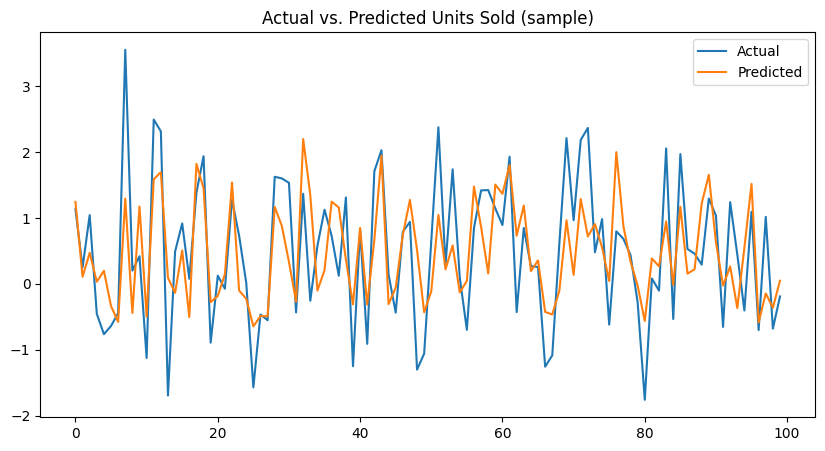

In [365]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(predictions[:100], label='Predicted')
plt.legend()
plt.title("Actual vs. Predicted Units Sold (sample)")
plt.show()

